# Import Libaray and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, BatchNormalization ,LeakyReLU
from tensorflow.keras.optimizers import Adam ,AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras.optimizers.schedules import ExponentialDecay

2025-06-24 18:31:28.509753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750789888.680914      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750789888.731605      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Loading**

In [2]:
df_scaled = pd.read_csv("/kaggle/input/airbnb-selected-scaled-features/airbnb_df_scaled_selected_features.csv") 

In [3]:
df_scaled

,price,bathrooms,beds,guests,bedrooms,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,...,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Åland Islands,price_per_bed,price_per_guest,bedroom_per_guest,bathroom_per_guest,bed_bath_ratio
0,8078,-0.428088,-0.694679,-0.805432,0.165004,0,0,0,0,0,...,0,0,0,0,0,8078.00,4039.000,1.00,0.50,1.0
1,4665,0.356389,-0.310641,-0.205145,0.165004,0,0,0,0,0,...,0,0,0,0,0,2332.50,1166.250,0.50,0.50,1.0
2,5991,-0.428088,0.073398,-0.205145,-0.530728,0,0,0,0,0,...,0,0,0,0,0,1997.00,1497.750,0.25,0.25,3.0
3,11339,-0.428088,-0.310641,-0.205145,-0.530728,0,0,0,0,0,...,0,0,0,0,0,5669.50,2834.750,0.25,0.25,2.0
4,6673,-0.428088,-0.694679,-0.805432,-0.530728,0,0,0,0,0,...,0,0,0,0,0,6673.00,3336.500,0.50,0.50,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11527,20311,0.356389,0.457436,0.995429,1.556467,0,0,0,0,0,...,0,0,0,0,0,5077.75,2538.875,0.50,0.25,2.0
11528,4288,5.063249,-1.078717,-0.205145,-1.226459,0,0,0,0,0,...,0,0,0,0,0,0.00,1072.000,0.00,2.00,0.0
11529,15200,-1.212565,-0.694679,-0.805432,-0.530728,0,0,0,0,0,...,0,0,0,0,0,15200.00,7600.000,0.50,0.00,0.0
11530,9103,-0.428088,-0.310641,-0.805432,-0.530728,0,0,0,0,0,...,0,0,0,0,0,4551.50,4551.500,0.50,0.50,2.0


In [4]:
numerical_cols = ['bathrooms', 'beds', 'guests', 'bedrooms']
print(df_scaled[numerical_cols].describe())

          bathrooms          beds        guests      bedrooms
count  1.153200e+04  1.153200e+04  1.153200e+04  1.153200e+04
mean   3.696892e-17  7.886704e-17 -4.929190e-17 -1.084422e-16
std    1.000043e+00  1.000043e+00  1.000043e+00  1.000043e+00
min   -1.212565e+00 -1.078717e+00 -1.105576e+00 -1.226459e+00
25%   -4.280881e-01 -6.946791e-01 -8.054322e-01 -5.307277e-01
50%   -4.280881e-01 -3.106408e-01 -2.051450e-01 -5.307277e-01
75%    3.563886e-01  7.339754e-02  3.951423e-01  1.650040e-01
max    5.063249e+00  5.065896e+00  3.396578e+00  4.339394e+00


 To enhance feature representation, new ratio-based features such as price_per_bed, price_per_guest, bedroom_per_guest, bathroom_per_guest, and bed_bath_ratio were engineered. These derived features help capture relative value and density aspects that raw features might not fully convey. 

After handling any division-related missing values, standard feature scaling was applied to selected numerical columns to normalize their distribution. This ensures that all features contribute equally to model training, especially for distance-based or gradient-sensitive algorithms.

# Spliting the Dataset

In [5]:
# Define features and target
X = df_scaled.drop('price', axis=1)
y = df_scaled['price']

In [6]:
# Split into train and test sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (9225, 125)
Test shape: (2307, 125)


# **Step 3: Model Creation:**
#  Custom ANN

In [8]:
def build_ann_model(input_dim):
    model = Sequential()

    model.add(Dense(512, kernel_initializer='he_normal', input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(64, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(1))  # Regression output

    optimizer = AdamW(learning_rate=0.002, weight_decay=1e-4)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# K-Fold Cross-Validation

In [9]:
# Set up K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []

mse_scores_rf = []
mae_scores_rf = []

mse_scores_xgb = []
mae_scores_xgb = []

mse_scores_combo = []
mae_scores_combo = []

# ANN Model Training And Evaluating

So here we build A custom Artificial Neural Network (ANN) designed for Airbnb price prediction, using multiple dense layers with LeakyReLU activation, batch normalization, and dropout for regularization. 

The AdamW optimizer was used with a specified learning rate and weight decay to improve convergence. To ensure robust performance evaluation, 10-fold cross-validation was applied. 

Early stopping and learning rate reduction callbacks were used during training to prevent overfitting and optimize training efficiency. 

Mean Squared Error (MSE) and Mean Absolute Error (MAE) were calculated for each fold to assess the model’s performance.

In [13]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = build_ann_model(input_dim=X.shape[1])

    early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                  verbose=1, min_lr=1e-6)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=64,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    y_pred = model.predict(X_val, verbose=0)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    print(f"Fold {fold + 1}: MSE = {mse:.2f}, MAE = {mae:.2f}")
    mse_scores.append(mse)
    mae_scores.append(mae)



Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750790379.776677      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1750790384.576793     250 service.cc:148] XLA service 0x4b4f9480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750790384.577298     250 service.cc:156]   StreamExecutor device (0): Tesla P10


Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 123: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 163: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 173: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 198: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Fold 1: MSE = 1395754.58, MAE = 559.44

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 99: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 145: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 167: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 177: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 187: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Fold 2: MSE = 1075696.05, MAE = 536.96

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=  10.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=250; total time=  16.7s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  14.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=  15.2s
[CV] END max_depth=25, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=  17.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=200; total time=  10.2s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END max_depth=20, max_features

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 118: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 145: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 168: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 178: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 188: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Fold 4: MSE = 643688.85, MAE = 478.59

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 85: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 105: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 125: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 141: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 152: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 162: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 172: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Fold 5: MSE = 906842.33, MAE = 541.87

Fold 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 74: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 109: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 124: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 154: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 164: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 174: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Fold 6: MSE = 825621.87, MAE = 533.51

Fold 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 93: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 119: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 138: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 161: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 171: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 184: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 194: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Fold 7: MSE = 963363.24, MAE = 498.27

Fold 8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 112: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 144: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 166: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 176: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 186: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Fold 8: MSE = 1098604.39, MAE = 542.45

Fold 9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 119: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 156: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 166: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 183: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 193: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Fold 9: MSE = 778864.31, MAE = 476.69

Fold 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 155: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 171: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Fold 10: MSE = 707061.74, MAE = 460.60


# ANN Cross-Validation Performance

In [14]:
print("\nFinal ANN Performance:")
print(f"Average MSE: {np.mean(mse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")


Final ANN Performance:
Average MSE: 930020.56
Average MAE: 516.67


In [15]:
# Create DataFrame with actual and predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': y_val.values.flatten(),
    'Predicted Price': y_pred.flatten()
})

# Show top 20
comparison_df.head(20)

,Actual Price,Predicted Price
0,6673,6758.427246
1,14729,14690.763672
2,30486,26532.468750
3,9028,8931.847656
4,6181,6492.014160
5,2740,1944.786377
6,5409,5594.403809
7,6505,6605.505859
8,5640,5660.354492
9,6165,6268.212891


# Random Forest

We considered A Random Forest Regressor that is optimized using RandomizedSearchCV to find the best combination of hyperparameters, such as the number of trees, maximum depth, and minimum sample requirements.

In [10]:
param_dist = {
    'n_estimators': [150, 200, 250, 300, 350],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt']
}

# Create base model
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit model
random_search.fit(X, y)

# Best parameters
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters: {'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20}


The search here was performed with 5-fold cross-validation, using negative MAE as the scoring metric. 

Once the optimal parameters were selected, the model is now for training and evaluating using 10-fold cross-validation. 

Mean Squared Error (MSE) and Mean Absolute Error (MAE) were calculated for each fold to assess the model’s accuracy and generalization performance.

In [11]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = RandomForestRegressor(**random_search.best_params_, random_state=42, n_jobs=-1)
    model.fit(X_tr, y_tr)

    y_pred_rf1 = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_rf1)
    mae = mean_absolute_error(y_val, y_pred_rf1)

    print(f"Fold {fold + 1}: MSE = {mse:.2f}, MAE = {mae:.2f}")
    mse_scores_rf.append(mse)
    mae_scores_rf.append(mae)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 1: MSE = 30411.83, MAE = 46.57


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 2: MSE = 18672.75, MAE = 40.22


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 3: MSE = 9014.25, MAE = 33.08


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 4: MSE = 37755.28, MAE = 48.49


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 5: MSE = 34564.68, MAE = 44.49


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 6: MSE = 13310.80, MAE = 35.25


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 7: MSE = 23017.74, MAE = 42.69


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 8: MSE = 86193.55, MAE = 43.85


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 9: MSE = 26473.95, MAE = 42.00


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Fold 10: MSE = 13668.87, MAE = 34.84


In [12]:
print("\nRandom Forest Final Performance:")
print(f"Average MSE: {np.mean(mse_scores_rf):.2f}")
print(f"Average MAE: {np.mean(mae_scores_rf):.2f}")


Random Forest Final Performance:
Average MSE: 29308.37
Average MAE: 41.15


To evaluate model performance more concretely, a comparison DataFrame was created displaying actual vs. predicted prices from the validation set. 

This allows for a direct, side-by-side assessment of how closely the model's predictions align with real values. The top 20 rows were shown to visually inspect prediction accuracy.

In [16]:
# Create DataFrame with actual and predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': y_val.values.flatten(),
    'Predicted Price': y_pred_rf1.flatten()
})

# Show top 20
comparison_df.head(20)

,Actual Price,Predicted Price
0,6673,6665.895003
1,14729,14667.904765
2,30486,29995.638410
3,9028,9027.564240
4,6181,6173.590114
5,2740,2717.066690
6,5409,5448.847999
7,6505,6505.374029
8,5640,5627.628619
9,6165,6170.567657


# XGBoost Model

An XGBoost Regressor is built with carefully tuned hyperparameters to improve predictive accuracy and control overfitting.
The model is evaluated using 10-fold cross-validation to ensure reliable performance across different subsets of the data. 

In [17]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")
    
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]  

    xgb = XGBRegressor(
        n_estimators=314,              
        learning_rate=0.07,            
        max_depth=9,
        subsample=0.94,
        colsample_bytree=0.97,
        gamma=0.26,
        reg_alpha=0.15,
        reg_lambda=1.46,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_tr, y_tr)

    # Predict and evaluate
    y_pred_xgb1 = xgb.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_xgb1)
    mae = mean_absolute_error(y_val, y_pred_xgb1)

    print(f"Fold {fold + 1}: MSE = {mse:.2f}, MAE = {mae:.2f}")
    mse_scores_xgb.append(mse)
    mae_scores_xgb.append(mae)


Fold 1
Fold 1: MSE = 103975.78, MAE = 100.26

Fold 2
Fold 2: MSE = 36285.83, MAE = 80.13

Fold 3
Fold 3: MSE = 60603.60, MAE = 93.03

Fold 4
Fold 4: MSE = 81475.01, MAE = 94.24

Fold 5
Fold 5: MSE = 48065.17, MAE = 91.03

Fold 6
Fold 6: MSE = 37993.59, MAE = 77.24

Fold 7
Fold 7: MSE = 65361.19, MAE = 88.92

Fold 8
Fold 8: MSE = 70613.04, MAE = 83.81

Fold 9
Fold 9: MSE = 79555.69, MAE = 93.04

Fold 10
Fold 10: MSE = 37758.76, MAE = 77.94


So, In each fold, the model was trained on 90% of the data and validated on the remaining 10%. 

Performance was assessed using Mean Squared Error (MSE) and Mean Absolute Error (MAE), with average scores reported to summarize the model’s overall effectiveness in predicting Airbnb listing prices.

In [18]:
# Final average performance
print("\nXGBoost Cross-Validation Performance:")
print(f"Average MSE: {np.mean(mse_scores_xgb):.2f}")
print(f"Average MAE: {np.mean(mae_scores_xgb):.2f}")


XGBoost Cross-Validation Performance:
Average MSE: 62168.76
Average MAE: 87.96


In [19]:
# Create DataFrame with actual and predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': y_val.values.flatten(),
    'Predicted Price': y_pred_xgb1.flatten()
})

# Show top 20
comparison_df.head(20)

,Actual Price,Predicted Price
0,6673,6648.121094
1,14729,14835.821289
2,30486,30458.361328
3,9028,9014.128906
4,6181,6218.163086
5,2740,2760.556396
6,5409,5255.331543
7,6505,6495.687988
8,5640,5699.026367
9,6165,6191.525879


# **4.4Ensemble Methods**
**Combined Model** 

In [20]:
# Loop over K-Folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # === Train ANN ===
    ann = build_ann_model(input_dim=X.shape[1])
    early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, min_lr=1e-6)
    ann.fit(X_train, y_train, validation_data=(X_val, y_val),
            epochs=200, batch_size=64, callbacks=[early_stop, reduce_lr], verbose=0)
    y_pred_ann = ann.predict(X_val, verbose=0).flatten()

    # === Train Random Forest ===
    rf = RandomForestRegressor(n_estimators=250, max_depth=15, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)

    # === Train XGBoost ===
    xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8, random_state=42)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_val)

    # === Ensemble: Average predictions ===
    y_pred_ensemble = (y_pred_ann + y_pred_rf + y_pred_xgb) / 3

    mse = mean_squared_error(y_val, y_pred_ensemble)
    mae = mean_absolute_error(y_val, y_pred_ensemble)

    print(f"Fold {fold + 1} MSE: {mse:.2f}, MAE: {mae:.2f}")
    mse_scores_combo.append(mse)
    mae_scores_combo.append(mae)


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 1 MSE: 247508.72, MAE: 213.40

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 2 MSE: 123949.00, MAE: 170.39

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 3 MSE: 122726.38, MAE: 190.47

Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 4 MSE: 101691.52, MAE: 181.03

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 5 MSE: 133824.38, MAE: 208.59

Fold 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 6 MSE: 79475.86, MAE: 175.85

Fold 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 7 MSE: 117055.08, MAE: 176.43

Fold 8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 8 MSE: 144880.10, MAE: 177.54

Fold 9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 9 MSE: 138869.68, MAE: 188.56

Fold 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Fold 10 MSE: 105420.48, MAE: 180.41


In [21]:
# === Final Evaluation ===
print("\nEnsemble Performance Summary:")
print(f"Average MSE: {np.mean(mse_scores_combo):.2f}")
print(f"Average MAE: {np.mean(mae_scores_combo):.2f}")


Ensemble Performance Summary:
Average MSE: 131540.12
Average MAE: 186.27


In [22]:
# Create DataFrame with actual and predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': y_val.values.flatten(),
    'Predicted Price': y_pred_ensemble.flatten()
})

# Show top 20
comparison_df.head(20)

,Actual Price,Predicted Price
0,6673,6775.828412
1,14729,15011.824465
2,30486,29020.736064
3,9028,9086.668309
4,6181,6352.734012
5,2740,2469.433243
6,5409,5407.575788
7,6505,6586.870469
8,5640,5564.301759
9,6165,6227.326822


# Model Comparision

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


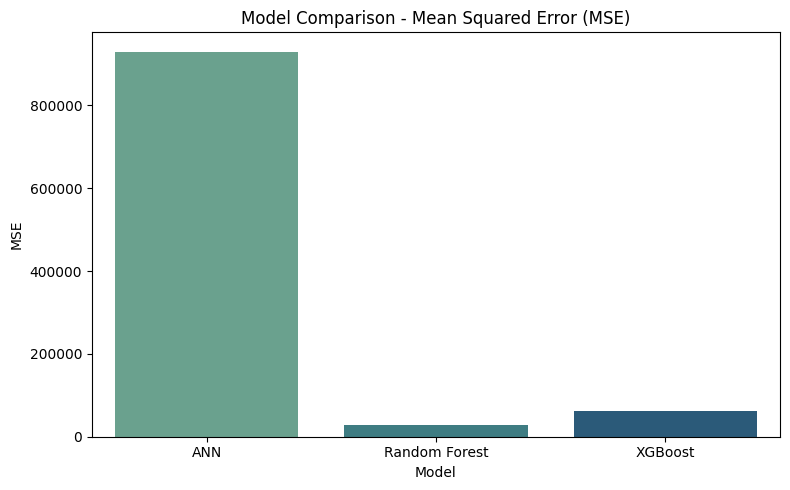

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


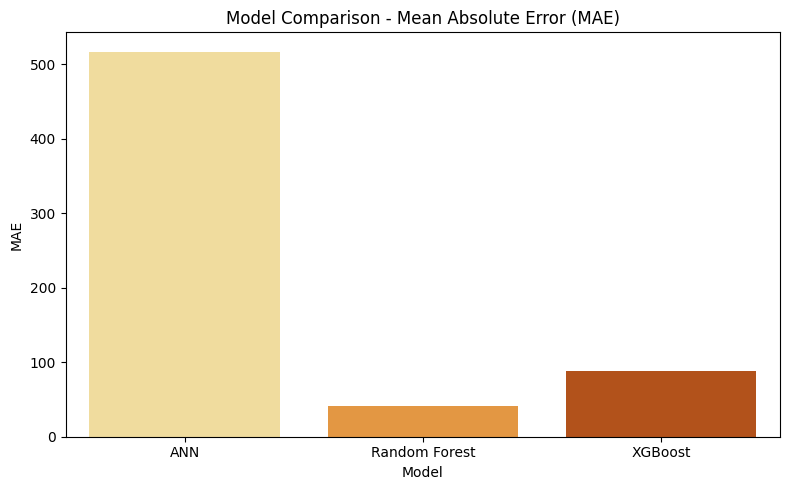

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# final scores from folds
mse_ann = np.mean(mse_scores)
mae_ann = np.mean(mae_scores)

mse_rf = np.mean(mse_scores_rf)        
mae_rf = np.mean(mae_scores_rf)        

mse_xgb = np.mean(mse_scores_xgb)
mae_xgb = np.mean(mae_scores_xgb)

# Combine in dicts
models = ['ANN', 'Random Forest', 'XGBoost']
mse_values_plot = [mse_ann, mse_rf, mse_xgb]
mae_values_plot = [mae_ann, mae_rf, mae_xgb]

# Plot MSE Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=mse_values_plot, palette='crest')
plt.title('Model Comparison - Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()

# Plot MAE Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=mae_values_plot, palette='YlOrBr')
plt.title('Model Comparison - Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


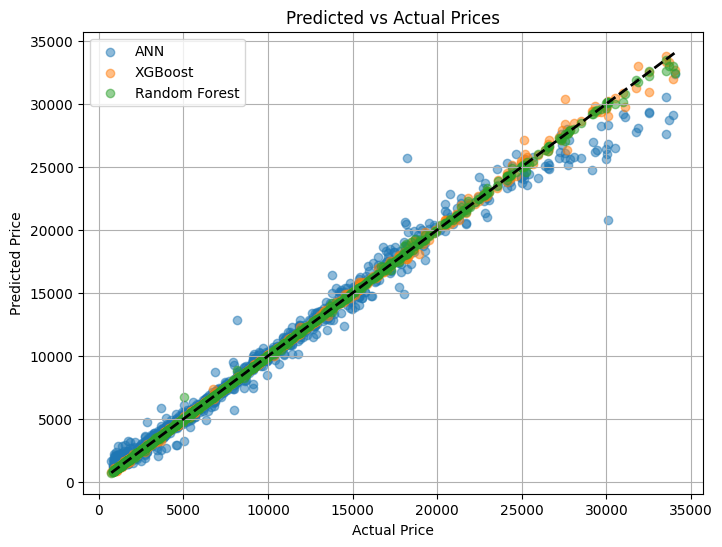

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, label='ANN', alpha=0.5)
plt.scatter(y_val, y_pred_xgb1, label='XGBoost', alpha=0.5)
plt.scatter(y_val, y_pred_rf1, label='Random Forest', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
errors_ann = y_val - y_pred.flatten()
errors_xgb = y_val - y_pred_xgb1.flatten()
errors_rf = y_val - y_pred_rf1.flatten()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


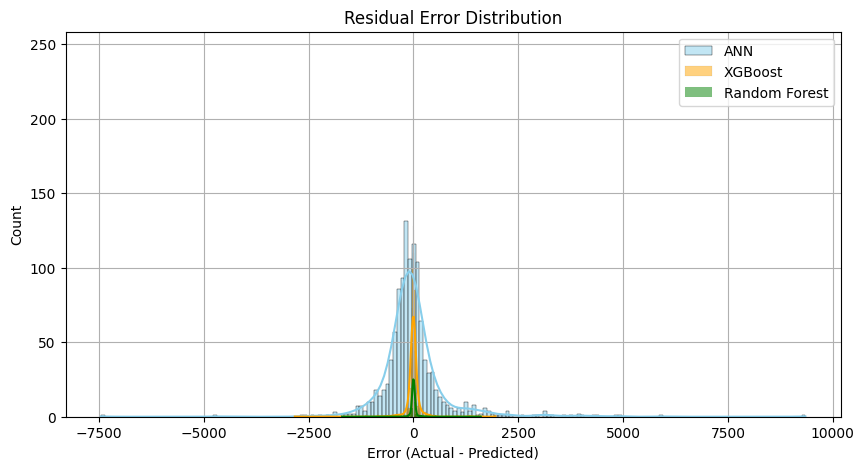

In [31]:
plt.figure(figsize=(10, 5))
sns.histplot(errors_ann, kde=True, label='ANN', color='skyblue')
sns.histplot(errors_xgb, kde=True, label='XGBoost', color='orange')
sns.histplot(errors_rf, kde=True, label='Random Forest', color='green')
plt.title('Residual Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.legend()
plt.grid(True)
plt.show()


# **Conclusion**

Among the three models, Random Forest achieved the best performance with the lowest MAE (~ 41), indicating highly accurate predictions.
XGBoost followed closely with a moderate MAE (~ 88) and good generalization across folds.
The custom ANN model, while performing consistently, had a higher MAE ( ~ 517), suggesting room for further tuning or feature enhancement.
and the combined MAE is 186.27


Overall, tree-based models (especially Random Forest) proved more effective for this Airbnb price prediction task.